## Gameroff _ McNulty MVP (NAMCS Data Project)


In [596]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Note:

**Dataset**: National Ambulatory Medical Care Survey (2012 data file)

**Label**: Intentional (vs. unintentional) physical injury to self

**Features considered:** age, sex, race/ethnicity, private insurance (rough proxy for SES), current tobacco use, total number of chronic medical conditions.

**Issues and Strategy**: Intentionality is relatively rare. Classes are extremely unbalanced (43:1).
As a first strategy, model with logistic regression, attempt to make classes more balanced by undersampling the majority class and oversampling the minority class. Training/testing data ratio: 75%/25%. (Later refinements will include more sophisticated oversampling method [SMOTE], using other ML methods [e.g., SVM], considering polynomials and/or interactions among features, etc.)

## Included in this notebook:
- Selected cells showing some of my work
- _**AT THE VERY BOTTOM OF THIS NOTEBOOK**_ are graphs showing score, recall, and prediction values at different weight settings for the minority class (weights of 1.0, 2.0, 5.0, and 10.0). These weights are probably too high. Further work with other estimators will attempt to keep them between 1.0 and 2.0.
    - There are 10 graphs, for every combination of penalty type (L1 vs, L2) and selected values of C (0.001, 0.01, 1, 10, 100)


In [599]:
df.INTENT.value_counts()

-9    73791
 1     2475
 2       57
-8        7
Name: INTENT, dtype: int64

In [614]:
from patsy import dmatrices
y, X = dmatrices('intent ~ age + sex + totchron + priv_insurance + curtobac + C(RACERETH)', \
                 data=df2, return_type = 'dataframe')

In [615]:
X.head()

,Intercept,C(RACERETH)[T.2.0],C(RACERETH)[T.3.0],C(RACERETH)[T.4.0],age,sex,totchron,priv_insurance,curtobac
0,1,0,0,0,80,0,2,0,0
1,1,0,0,0,70,1,1,0,0
2,1,1,0,0,14,0,0,1,0
3,1,0,1,0,12,1,0,1,0
4,1,0,0,0,30,0,0,0,0


In [616]:
y.head()

,intent
0,0
1,0
2,0
3,0
4,0


In [618]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [619]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1899, 9)
(1899, 1)
(633, 9)
(633, 1)


In [620]:
X_train = X_train.replace(-6, -9)
X_train = X_train.replace(-7, -9)
X_train = X_train.replace(-8, -9)
X_train = X_train.replace(-9, -9)

X_test = X_test.replace(-6, -9)
X_test = X_test.replace(-7, -9)
X_test = X_test.replace(-8, -9)
X_test = X_test.replace(-9, -9)

In [621]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=-9, strategy='median', axis=0, verbose=1)
imp.fit(X_train)

Imputer(axis=0, copy=True, missing_values=-9, strategy='median', verbose=1)

In [622]:
X_train_imputed = pd.DataFrame(imp.transform(X_train))

In [623]:
X_test_imputed = pd.DataFrame(imp.transform(X_test))

In [624]:
print(X_train_imputed.shape)
print(X_test_imputed.shape)
print(y_train.shape)
print(y_test.shape)

(1899, 9)
(633, 9)
(1899, 1)
(633, 1)


In [625]:
X_train_imputed.rename(columns={0: 'Intercept', 1:'C(RACERETH)[T.2.0]', \
          2: 'C(RACERETH)[T.3.0]',  3 : 'C(RACERETH)[T.4.0]', \
          4: 'age',   5: 'sex',  6: 'totchron', \
          7: 'priv_insurance', 8: 'curtobac'}, inplace=True)
X_test_imputed.rename(columns={0: 'Intercept', 1:'C(RACERETH)[T.2.0]', \
          2: 'C(RACERETH)[T.3.0]',  3 : 'C(RACERETH)[T.4.0]', \
          4: 'age',   5: 'sex',  6: 'totchron', \
          7: 'priv_insurance', 8: 'curtobac'}, inplace=True)

In [626]:
X_train_imputed.head()

,Intercept,C(RACERETH)[T.2.0],C(RACERETH)[T.3.0],C(RACERETH)[T.4.0],age,sex,totchron,priv_insurance,curtobac
0,1,0,1,0,21,0,0,1,0
1,1,0,0,0,78,0,4,0,0
2,1,0,0,0,32,0,0,1,0
3,1,0,0,0,52,1,0,1,0
4,1,0,1,0,53,1,0,0,0


In [627]:
X_test_imputed.head()

,Intercept,C(RACERETH)[T.2.0],C(RACERETH)[T.3.0],C(RACERETH)[T.4.0],age,sex,totchron,priv_insurance,curtobac
0,1,0,0,0,56,1,1,0,0
1,1,0,1,0,45,0,1,1,0
2,1,0,0,0,33,1,0,1,0
3,1,0,0,0,56,0,1,0,0
4,1,0,0,0,20,0,0,1,0


In [628]:
#print ('Intent: ', X_train_imputed['intent'].unique())
print ('Age: ', X_train_imputed['age'].unique())
print ('Sex: ', X_train_imputed['sex'].unique())
print ('No. of chronic disorders: ', X_train_imputed['totchron'].unique())
print ('Private insurance ', X_train_imputed['priv_insurance'].unique())
print ('Current tobacco: ', X_train_imputed['curtobac'].unique())

print ('RACERETH 1: ', X_train_imputed['C(RACERETH)[T.2.0]'].unique())
print ('RACERETH 2: ', X_train_imputed['C(RACERETH)[T.2.0]'].unique())
print ('RACERETH 3: ', X_train_imputed['C(RACERETH)[T.2.0]'].unique())

Age:  [ 21.  78.  32.  52.  53.  29.  28.  92.  67.  14.  48.  63.  26.  46.  34.
  16.  57.  85.  47.  65.  18.  12.  36.  51.  61.  45.  68.  42.  15.  55.
  60.  87.  54.   9.  24.  30.  31.  56.   8.  19.  10.  20.   2.  13.  38.
  11.  62.  37.  41.   3.  69.  33.   7.  72.  79.   5.  59.  22.  39.  44.
  70.  35.  71.  50.  25.  81.  40.  90.  49.  27.  58.  73.  17.  75.   4.
   6.  23.  76.  80.  82.  74.  86.  43.   1.  84.   0.  77.  64.  89.  66.
  88.  91.  83.]
Sex:  [ 0.  1.]
No. of chronic disorders:  [  0.   4.   2.   1.   3.   5.   6.  10.   7.]
Private insurance  [ 1.  0.]
Current tobacco:  [ 0.  1.]
RACERETH 1:  [ 0.  1.]
RACERETH 2:  [ 0.  1.]
RACERETH 3:  [ 0.  1.]


In [629]:
#print ('Intent: ', X_train_imputed['intent'].unique())
print ('Age: ', X_test_imputed['age'].unique())
print ('Sex: ', X_test_imputed['sex'].unique())
print ('No. of chronic disorders: ', X_test_imputed['totchron'].unique())
print ('Private insurance ', X_test_imputed['priv_insurance'].unique())
print ('Current tobacco: ', X_test_imputed['curtobac'].unique())

print ('RACERETH 1: ', X_test_imputed['C(RACERETH)[T.2.0]'].unique())
print ('RACERETH 2: ', X_test_imputed['C(RACERETH)[T.2.0]'].unique())
print ('RACERETH 3: ', X_test_imputed['C(RACERETH)[T.2.0]'].unique())


Age:  [ 56.  45.  33.  20.  38.  29.  67.  49.  15.  53.  58.  78.  36.  62.  59.
  48.  35.  44.  13.  69.   6.  43.  17.  21.   4.   0.  81.  64.  24.  87.
  11.  63.   8.  32.  47.  46.  54.  30.   2.   5.  25.  39.  41.  14.  86.
  61.  50.   9.  12.  66.  65.   3.  16.  75.  71.  10.  55.  85.   7.  37.
  76.  26.  51.  73.  40.  52.  22.  19.  57.  80.  42.  28.  18.   1.  34.
  83.  23.  68.  82.  72.  27.  77.  70.  60.  92.  74.  79.  31.]
Sex:  [ 1.  0.]
No. of chronic disorders:  [ 1.  0.  2.  3.  4.  5.  8.  6.  7.]
Private insurance  [ 0.  1.]
Current tobacco:  [ 0.  1.]
RACERETH 1:  [ 0.  1.]
RACERETH 2:  [ 0.  1.]
RACERETH 3:  [ 0.  1.]


In [1034]:
df_sort.info()
df_sort

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 27 to 21
Data columns (total 7 columns):
penalty        40 non-null object
C              40 non-null float64
majority_wt    40 non-null float64
minority_wt    40 non-null float64
score          40 non-null float64
recall         40 non-null float64
predict        40 non-null float64
dtypes: float64(6), object(1)
memory usage: 2.5+ KB


,penalty,C,majority_wt,minority_wt,score,recall,predict
27,L1,0.001,0.2,1,0.977883,0.000000,0.000000
6,L1,0.001,0.2,2,0.977883,0.000000,0.000000
16,L1,0.001,0.2,5,0.977883,0.000000,0.000000
3,L1,0.001,0.2,10,0.977883,0.000000,0.000000
31,L1,0.010,0.2,1,0.977883,0.000000,0.000000
7,L1,0.010,0.2,2,0.977883,0.000000,0.000000
34,L1,0.010,0.2,5,0.977883,0.000000,0.000000
15,L1,0.010,0.2,10,0.977883,0.000000,0.000000
39,L1,1.000,0.2,1,0.971564,0.000000,0.000000
2,L1,1.000,0.2,2,0.941548,0.142857,0.074074


In [1095]:
def plotme (data,ddd):
    fig, ax = plt.subplots()
    line1 = ax.plot(df2.minority_wt, df2.recall,  '-', color='blue')
    #ax.plot(df2.minority_wt, df2.recall,  'o', color='blue')
    line2 = ax.plot(df2.minority_wt, df2.predict,  '-', color='red')
    #ax.plot(df2.minority_wt, df2.predict,  'o', color='red')
    line3 = ax.plot(df2.minority_wt, df2.score,  '-', color='green')
    #ax.plot(df2.minority_wt, df2.score,  'o', color='green')    
    #ax.set_ylim(0,1)
    #ax.set_xlim(0,1)
    #ax_legend
    handles, labels = ax.get_legend_handles_labels()
    #print (handles, labels)
    ax.legend(handles, labels)
    ax.legend(bbox_to_anchor=[1.15, .7], loc='lower center', ncol=1)
    #ax.legend((line1, line2, line3), ('recall', 'predict', 'score'))
    ax.set_xlabel('Weight of minority class')
    ax.set_ylabel('Value')
    ax.set_title(ddd)
    plt.show()

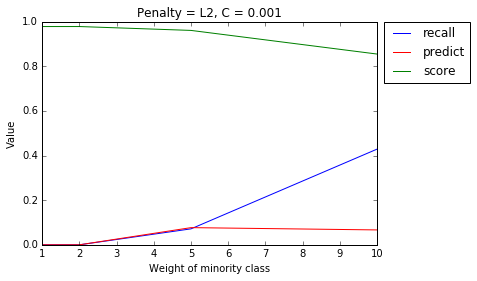

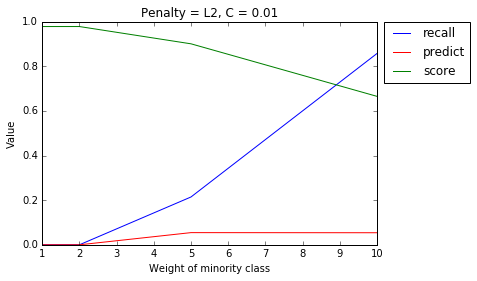

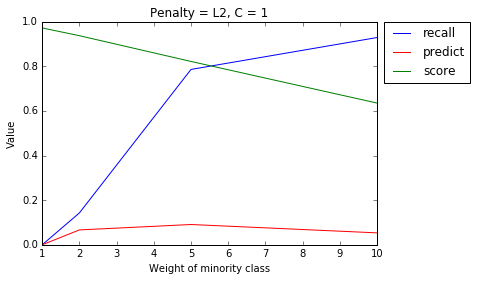

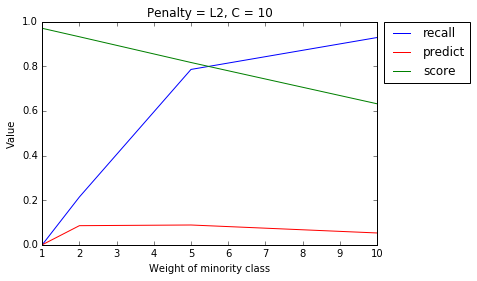

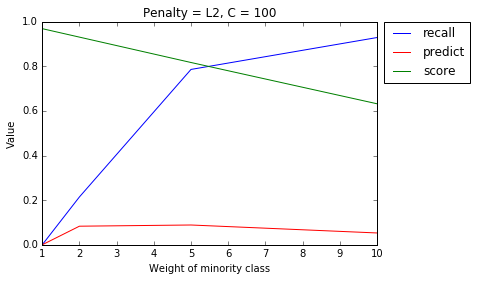

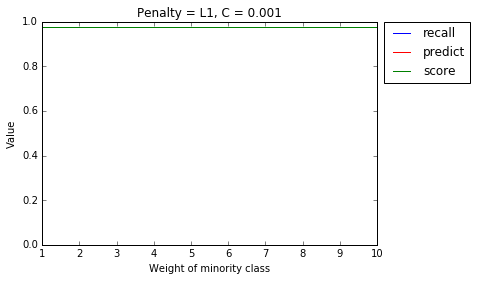

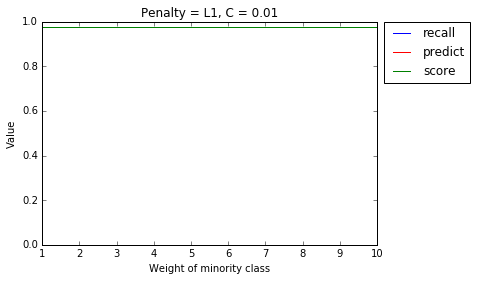

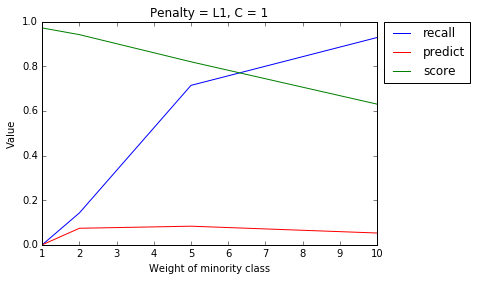

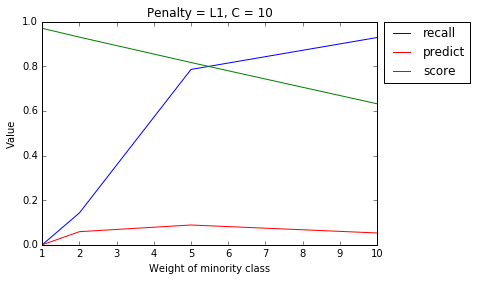

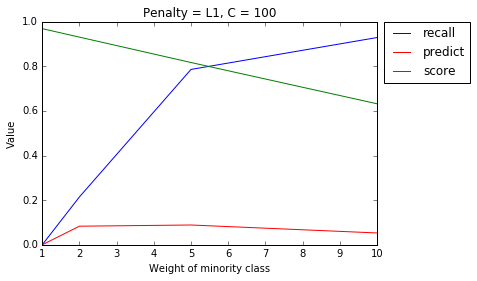

In [1098]:
df2 = df_sort[(df_sort["penalty"] == 'L2') & (df_sort["C"] == .001)]
plotme(df2,'Penalty = L2, C = 0.001')
df2 = df_sort[(df_sort["penalty"] == 'L2') & (df_sort["C"] == .01)]
plotme(df2,'Penalty = L2, C = 0.01')
df2 = df_sort[(df_sort["penalty"] == 'L2') & (df_sort["C"] == 1)]
plotme(df2,'Penalty = L2, C = 1')
df2 = df_sort[(df_sort["penalty"] == 'L2') & (df_sort["C"] == 10)]
plotme(df2,'Penalty = L2, C = 10')
df2 = df_sort[(df_sort["penalty"] == 'L2') & (df_sort["C"] == 100)]
plotme(df2,'Penalty = L2, C = 100')

df2 = df_sort[(df_sort["penalty"] == 'L1') & (df_sort["C"] == .001)]
plotme(df2,'Penalty = L1, C = 0.001')
df2 = df_sort[(df_sort["penalty"] == 'L1') & (df_sort["C"] == .01)]
plotme(df2,'Penalty = L1, C = 0.01')
df2 = df_sort[(df_sort["penalty"] == 'L1') & (df_sort["C"] == 1)]
plotme(df2,'Penalty = L1, C = 1')
df2 = df_sort[(df_sort["penalty"] == 'L1') & (df_sort["C"] == 10)]
plotme(df2,'Penalty = L1, C = 10')
df2 = df_sort[(df_sort["penalty"] == 'L1') & (df_sort["C"] == 100)]
plotme(df2,'Penalty = L1, C = 100')